# VGG-16

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [34]:
gpus = tf.config.list_physical_devices('cpu')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [35]:
import matplotlib.pyplot as plt
#%matplotlib inline

In [36]:
# 2) 상수 정의
HEIGHT, WIDTH = 49, 37
TRAIN_DIR = "/Volumes/sddrv/datasets/PKLot/cnn_dataset/train/"
VALID_DIR = "/Volumes/sddrv/datasets/PKLot/cnn_dataset/valid/"
BATCH_SIZE = 32
nb_train_samples = 5000
nb_validation_samples = 500
epochs = 10

In [37]:
# 3) ImageDataGenerator 설정
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
validation_generator = validation_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 5000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [38]:
# 4) 베이스 모델 정의 (VGG16, include_top=False)
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(HEIGHT, WIDTH, 3)
)
base_model.trainable = False  # 동결

In [39]:
print(base_model.summary())

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 49, 37, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 49, 37, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 49, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 9, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 9, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 9, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 9, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [40]:
# # Freeze the base model not to train
for layer in base_model.layers:
        layer.trainable = False

In [41]:
# 5) 분류기 헤드 추가
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
pred = Dense(1, activation='sigmoid')(x)

tf_model = Model(inputs=base_model.input, outputs=pred)


In [42]:
print(tf_model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 49, 37, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 49, 37, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 49, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 9, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 9, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 9, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 9, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [43]:
# 6) 컴파일
tf_model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(learning_rate=1e-4, momentum=0.9),
    metrics=['accuracy']
)

# tf_model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [44]:
# 7) 학습
tf_hist = tf_model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // BATCH_SIZE,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // BATCH_SIZE
)


Epoch 1/10


/Users/chohi/project/ai/Study/YOLOv11/PKLot/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7763 - loss: 2.4916 - val_accuracy: 0.8729 - val_loss: 0.7427
Epoch 2/10
  1/156 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - accuracy: 0.8750 - loss: 0.7825

/Users/chohi/project/ai/Study/YOLOv11/PKLot/.venv/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8750 - loss: 0.7825 - val_accuracy: 0.8729 - val_loss: 0.7351
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.9266 - loss: 0.5589 - val_accuracy: 0.8875 - val_loss: 0.5942
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9688 - loss: 0.1762 - val_accuracy: 0.8875 - val_loss: 0.6073
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.9367 - loss: 0.4534 - val_accuracy: 0.9042 - val_loss: 0.4948
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9062 - loss: 0.2819 - val_accuracy: 0.9062 - val_loss: 0.4938
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.9400 - loss: 0.4681 - val_accuracy: 0.8938 - val_loss: 0.4734
Epoch 8/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7500 - loss: 1.4188 - val_accuracy: 0.9042 - val_loss: 0.4602
Epoch 9/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 26s 166ms/step - accuracy: 0.9418 - loss: 0.3540 - val_accurac

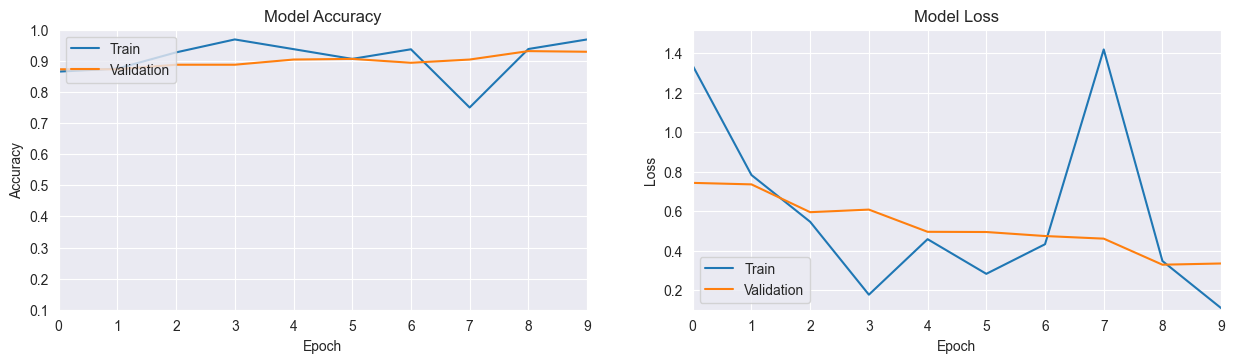

In [45]:
plt.figure(1, figsize=(15, 8))

# Plot accuracy
plt.subplot(221)
plt.plot(tf_hist.history['accuracy'])
plt.plot(tf_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0.1, 1.0)  # Set y-axis limits to start from 0.1
plt.xlim(0, len(tf_hist.history['accuracy']) - 1)  # Ensure x-axis aligns with the number of epochs

# Plot loss
plt.subplot(222)
plt.plot(tf_hist.history['loss'])
plt.plot(tf_hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.ylim(0.1, max(max(tf_hist.history['loss']), max(tf_hist.history['val_loss'])) + 0.1)  # Ensure y-axis starts at 0.1
plt.xlim(0, len(tf_hist.history['loss']) - 1)  # Ensure x-axis aligns with the number of epochs

plt.show()

## Model prediction on validation dataset

In [46]:
from glob import glob
import numpy as np
from PIL import Image
import cv2

In [47]:
occupied_dir = "/Volumes/sddrv/datasets/PKLot/cnn_dataset/valid/Occupied/*.jpg"
empty_dir = "/Volumes/sddrv/datasets/PKLot/cnn_dataset/valid/Empty/*.jpg"

valid_images = glob(occupied_dir) + glob(empty_dir)

In [48]:
valid_sample_size = 250 # To run  on complete valid dataset. Please set this to 50000 (value greater than number of valid images)
valid_images = list(valid_images)
np.random.shuffle(valid_images)
valid_images = valid_images[:valid_sample_size]

In [49]:
def load_image(path):
    # OpenCV는 기본적으로 BGR 순서로 읽어들임
    img_bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise FileNotFoundError(f"Image not found at: {path}")

    # BGR → RGB로 변환
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb

In [50]:
ground_truth = []
prediction = []
for img in valid_images:
    label = img.split("/")[-2]
    if label == "Occupied":
        ground_truth.append(1)
    else:
        ground_truth.append(0)
    image = load_image(img)
    image = cv2.resize(image, (WIDTH, HEIGHT))
    image_x = np.expand_dims(image, axis=0)
    image_x = preprocess_input(image_x)
    pred = tf_model.predict(image_x)
    pred = np.squeeze(pred)
    if pred > 0.98:
        prediction.append(1)
    else:
        prediction.append(0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━

### Validate the model

In [51]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#%matplotlib inline

In [52]:
print(classification_report(ground_truth, prediction, target_names=['Empty', 'Occupied']))

              precision    recall  f1-score   support

       Empty       0.99      0.96      0.97       139
    Occupied       0.96      0.98      0.97       111

    accuracy                           0.97       250
   macro avg       0.97      0.97      0.97       250
weighted avg       0.97      0.97      0.97       250



(array([0, 1]), array([136, 114]))


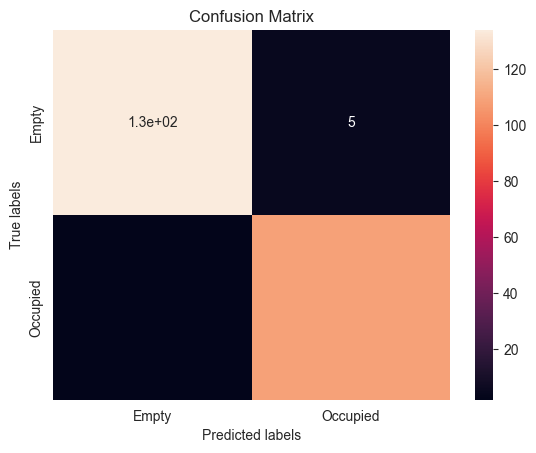

In [53]:
# confusion matrix
cm = confusion_matrix(ground_truth, prediction)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Empty', 'Occupied']);
ax.yaxis.set_ticklabels(['Empty', 'Occupied']);

print(np.unique(prediction, return_counts=True))


In [54]:
print("Confusion matrix")
print(cm)

Confusion matrix
[[134   5]
 [  2 109]]
